In [1]:
import numpy as np
import matplotlib.pyplot as plt

### To do:
- add marginal cost in the greedy controller
- Change the functions to never call global variable if possible
- plot instaneous path ratio
- Try with a different network
- Implement two player game

Later:
- Show expectation and standard deviation for Monte Carlo
- use scipy csc for the adjencency graph
- Implement cars with probabilities
- Try on Fremont network
- Do optimal control


# 1. Defining simulation inside network class

## Defining the class network that enables to perform some simulations

In [2]:
class network:
    def __init__(self, graph_dict):
        """
        Creating the network from dictionary
        """
        def create_connections(g):
            connections = np.zeros((1,2))
            for i in self.graph.keys():
                for j in self.graph[i]["connection"]:
                    connections = np.append(connections, [[i, j],], axis=0)
            connections = connections[1:]
            return connections
        
        def create_adj_line_graph(array):
            nb_links = array.shape[0]
            adj_matrix = np.zeros((nb_links,nb_links))
            for k in range(nb_links):
                adj_matrix[k][np.argwhere(array[:,0]==array[k][1])] = 1
            return adj_matrix
        
        # This dictionary is the graph
        self.graph = graph_dict
        self.connections = create_connections(self.graph)
        self.nb_links = self.connections.shape[0]
        self.__adj_matrix = create_adj_line_graph(self.connections)
        self.__mfd_set_up = False

    def set_up_mfd(self, v_max, x_max, c):
        """
        Set up macroscopic flow diagram to get travel time.
        """
        if not (self.is_valid_flow(x_max) & self.is_valid_flow(x_max) & self.is_valid_flow(x_max)):
            print("Incorrect vectors to set up to MFD")
            pass
        self.v_max = v_max
        self.x_max = x_max
        self.c = c
        self.__mfd_set_up = True

    def mfd_aux(self,x, v_max, x_max, c):
        if x == 0:
            return v_max
        if x >= x_max:
            return 0
        v = v_max*(1-np.exp((c/v_max) * (1-x_max/x)))
        return v
    
    def mfd(self,x, v_max, x_max, c):
        return x * self.mfd_aux(x, v_max, x_max, c)
    
    def update_matrix_from_with_mfd(self, mfd_v, P, des):
        """
        Given a stoachatics matrix, change it to take into account travel time on links.
        Change this function to implement congestion spill back.
        """
#         if not (self.is_valid_outflow_ratio(mfd_v) and self.is_valid_matrix_with_destination(P, des)):
#             print("Matrix or vector of travel time are not correct")
#             return -1
        matrix = - np.diag(np.ones(self.nb_links))
        for i in range(self.nb_links):
            matrix[i,:] = (matrix[i,:] + P[i,:]) * mfd_v[i]
        return matrix
        
    def update_flow_from_matrix_one_player(self, x, P, dt, des=-1):
        """
        One step of the flow dynamics given a stochastic matrix and a time step
        """
#         if not self.__mfd_set_up:
#             print("Please use set up MFD function before running the experiment")
#             return
#         if not self.is_valid_flow(x):
#             print("Flow vector x does not seems correctly defined")
#             return
#         if not self.is_valid_matrix_with_destination(P, des):
#             print("P does not seems to be a correct control matrix")
#             print(P)
#             return
        mfd_v = np.array([self.mfd_aux(x[i], self.v_max[i], self.x_max[i], self.c[i]) for i in range(self.nb_links)])
        matrix = self.update_matrix_from_with_mfd(mfd_v, P, des)
        x_t_1 = x + matrix.T @ x * dt
        return x_t_1
        
    def simulation_one_player(self, x0, nb_iteration, dt, controller, destination):
        """
        Simulate flow dynamics given a controller function that gives a stochastic matrix as a function of the flow allocation
        """
        x = x0
        # saving the results
        f = np.zeros((nb_iteration+1, g.nb_links))
        for t in range(nb_iteration):
            f[t] = x
            x = self.update_flow_from_matrix_one_player(x, controller(self, x, t), dt, destination)
        f[nb_iteration] = x
        return f
        
    def get_adj_matrix(self):
        """
        Return the adjency matrix of the line graph.
        """
        return self.__adj_matrix.copy()
        
    def get_mean_travel_time(self, x):
        """
        Give meanlife travel time on a link using the MFD
        """
        if not self.__mfd_set_up:
            print("Please use set up MFD function before running the experiment")
            return
        tt = np.zeros(self.nb_links)
        for i in range(self.nb_links):
            mfd_tmp = self.mfd_aux(x[i], self.v_max[i], self.x_max[i], self.c[i])
            if mfd_tmp == 0:
                tt[i] = 10**6
            else:
                tt[i] = 1/mfd_tmp
        return tt
        
    def get_weighted_matrix_aux(self, tt):
        """
        Give weighted_matrix given travel time on links
        """
        if not self.is_valid_flow(tt):
            print("Argument not valid, tt is not a vector of travel time")
            return
        matrix = g.get_adj_matrix()
        indices = np.nonzero(matrix)
        for i in range(len(indices[0])):
            j, k = indices[0][i], indices[1][i]
            matrix[j,k] = tt[k]
        return matrix
    
    def get_weighted_matrix(self, x):
        """
        Give weighted_matrix given flow on links
        """
        tt = self.get_mean_travel_time(x)
        return self.get_weighted_matrix_aux(tt)
    
    def plot_network(self):
        """
        Plot the network
        """
        %matplotlib inline
        links = np.zeros((self.nb_links, 4))
        for i in range(self.nb_links):
            links[i,:2] = self.graph[self.connections[i,0]]["location"]
            links[i,2:] = self.graph[self.connections[i,1]]["location"]
    
        plt.quiver(links[:, 0], links[:, 1], links[:, 2]-links[:, 0], links[:, 3]-links[:, 1], color="b", angles='xy', scale_units='xy', scale=1)
        plt.xlim([np.min(links[:, [0,2]])-0.5, np.max(links[:, [0,2]]) + 0.5])
        plt.ylim([np.min(links[:, [1,3]])-0.5, np.max(links[:, [1,3]]) + 0.5])
        plt.show()
        
    def plot_mfd(self, i, fs = 10):
        """
        Plot MFD for one link
        """
        %matplotlib inline
        if not isinstance(i, int):
            print("i should be an integer")
        if i>=self.nb_links or i<0:
            print("i should be in [0," + str(self.nb_links-1) + "]")
        values = np.arange(0, self.x_max[i], self.x_max[i]/100.)
        
        # change mfd_aux to mfd to get the mfd plot
        plt.plot(values, [self.mfd_aux(j, self.v_max[i], self.x_max[i], self.c[i]) for j in values], label="MFD of link " + str(i+1))
        plt.ylabel("Ratio of vehicle exiting in 1 unit of time", fontsize=fs)
        plt.xlabel("Number of vehicle on the link", fontsize=fs)
        plt.legend()
        plt.show()
    
    def plot_flow(self, x, fs = 10):
        """
        Plot flow results over time
        """
        %matplotlib inline
        if not isinstance(x, np.ndarray):
            print("Argument is not numpy array")
            return
        if not isinstance(x.shape,  tuple):
            print("Argument has not the correct shape")
            return
        n,m = x.shape
        if m!= self.nb_links:
            print("Shape should be (...," + str(self.nb_links) + "); it is " + str((n,m)))
            return
        for i in range(self.nb_links):
            plt.plot(x[:,i], label="flow on link " + str(i+1))
        plt.xlabel("Iteration", fontsize=fs)
        plt.ylabel("Link flow", fontsize=fs)
        plt.title("Link flow as a function of time", fontsize=fs)
        plt.legend(fontsize=fs)
        plt.show()

    def is_valid_flow(self, x):
        """
        Test that a flow is valid: numpy array with int positive values
        """
        if not isinstance(x, np.ndarray):
            return False
        return (x.size == self.nb_links) & (x >= 0).all()
    
    def is_valid_matrix(self, P):
        """
        Test that P is a valid stochatisc matrix
        """
        # P should be an array
        if not isinstance(P, np.ndarray):
            return False
        
        # P should has the same size as the graph
        if not P.shape == self.__adj_matrix.shape:
            return False
        
        # P should has 0 where adj_matrix has 0
        if not np.all(P[self.__adj_matrix == 0]==0):
            return False
        
        # element of P should be >=0
        if not np.all(P>=0):
            return False
        return True
    
    def is_valid_matrix_with_destination(self, P, destination):
        if not self.is_valid_matrix(P):
            return False
        for i in range(self.nb_links):
            if not i in destination:
                if np.sum(P[i,:])!=1:
                    return False
        return True
    
    def is_valid_outflow_ratio(self, x):
        if not isinstance(x, np.ndarray):
            return False
        return (x.size == self.nb_links) & (x >= 0).all() & (x <= 1).all()
        

# 2. Implementing simulation

## 2.1. Creating the network use for the experiment

In [3]:
# Maybe we can set up the MFD in the dictionary
# creating the graph
graph_dict = {0: {"connection": {1}, "location": [0, 0]},
              1: {"connection": {2, 3}, "location": [1, 0]},
              2: {"connection": {3, 4}, "location": [2, 1]},
              3: {"connection": {4}, "location": [2, -1]},
              4: {"connection": {5}, "location": [3, 0]},
              5: {"connection": {}, "location": [4, 0]}}
g = network(graph_dict)

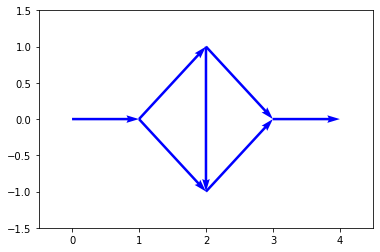

In [4]:
g.plot_network()
# print(g.connections)

## 2.2. Creating controllers

### 0. Cost and matrix creation functions for this specific network

In [5]:
def get_cost(f):
    return np.sum([np.sum(f[i,1:6]) for i in range(f.shape[0])])

# create a dummy controller
def matrix_from_u1_u2(g, u1, u2):    
    matrix = g.get_adj_matrix()
    matrix[0][1] = 1 - u1
    matrix[0][2] = u1
    matrix[1][3] = 1 - u2
    matrix[1][4] = u2
    return matrix

### A. Brute force controller

In [6]:
def get_brute_force_results(x0, nb_iteration, time_step, cost_function, matrix_constructor, nb_points_mesh, debug = False):
    scores_brute_force_list = np.zeros([nb_points_mesh+1, nb_points_mesh+1])
    for i in range(nb_points_mesh+1):
        u1 = i/nb_points_mesh
        for j in range(nb_points_mesh+1):
            u2 = j/nb_points_mesh
            f = g.simulation_one_player(x0, nb_iteration, time_step, lambda gvar, xvar, tvar: matrix_constructor(gvar, u1, u2), [dest])
            scores_brute_force_list[i][j] = cost_function(f)
        if debug and i % (nb_points_mesh/10) == 0:
            print(str(i*100 / nb_points_mesh) + " % done")

    # u_brute_force are global variables corresponding to optimal control found with brute force
    u1_brute_force_tmp, u2_brute_force_tmp = np.unravel_index(scores_brute_force_list.argmin(), scores_brute_force_list.shape)
    u_brute_force = [i / nb_points_mesh for i in [u1_brute_force_tmp, u2_brute_force_tmp]]

    # f_brute_force and score_brute_force are global variables associated to optimal control found with brute force
    f_brute_force = g.simulation_one_player(x0, nb_iteration, time_step, lambda gvar, xvar, tvar: matrix_constructor(gvar, u_brute_force[0], u_brute_force[1]), [dest])
    score_brute_force = get_cost(f_brute_force)

    return u_brute_force, f_brute_force, score_brute_force, scores_brute_force_list

### B. Greedy controller 1

Greedy controller 1 put everyone one the instantenous travel time at every time step

In [7]:
import scipy.sparse as scs

# x0, nb_iteration, time_step, origin and dest should be defined
# function get_cost should have been defined

def greedy_controller_1_aux(g, x, ori, des):
    def update_matrix_from_predecessor_matrix(G_sparse, pred, o, d, matrix):
        tree = scs.csgraph.reconstruct_path(csgraph=G_sparse, predecessors=pred[o], directed=True)
        t = np.nonzero(tree)
        i = d
        while i != o:
            j = np.argwhere(t[1]==i)[0][0]
            i = t[0][j]
            matrix[t[0][j], t[1][j]] = 1
        return matrix
    
    # creating adjacency sparse matrix with link travel time for weight
    G_sparse = scs.csr_matrix(g.get_weighted_matrix(x))
    # running shortest path algorithm on it
    cost, pred = scs.csgraph.shortest_path(G_sparse, method='auto', directed=True, return_predecessors=True, unweighted=False, overwrite=False)

    # creating the control matrix from the shortest_path results -> here we might optimize the code
    matrix = update_matrix_from_predecessor_matrix(G_sparse, pred, ori, des, np.zeros((g.nb_links,g.nb_links)))
    
    indices = np.argwhere(np.sum(matrix, axis=1)==0)[:,0]
    for k in indices:
        if k == 1:
            matrix = update_matrix_from_predecessor_matrix(G_sparse, pred, k, des, matrix)
        else:
            matrix[k] = g.get_adj_matrix()[k]
    return matrix



### B.bis. Greedy controller 2  --> To do

Greedy controller 2 put everyone one path that minimizes the instantenous travel time + marginal cost at every time step

In [8]:
## TO DO

### C. Monte Carlo controller

In [9]:
def monte_carlo_controller_aux(gv, x_init, nb_iter, tstep, des, cost_function, nb_trial, save_test=False, return_score=False):
    # nb_trial should be a strictly positive integer
    min_cost = np.inf
    
    if save_test:
        u_tested = np.zeros((nb_trial, 2))
    
    for i in range(nb_trial):
        u1 = np.random.random()
        u2 = np.random.random()
        if save_test:
            u_tested[i] = [u1, u2]
        f_test = gv.simulation_one_player(x_init, nb_iter, tstep, lambda gvar, xvar, tvar: matrix_from_u1_u2(gvar, u1, u2), [des])
        run_cost = cost_function(f_test)
        if run_cost < min_cost:
            u_monte_carlo_tmp = [u1, u2]
            min_cost = run_cost

    if save_test:
        return u_tested, u_monte_carlo_tmp
    if return_score:
        return u_monte_carlo_tmp, min_cost
    return matrix_from_u1_u2(gv, u_monte_carlo_tmp[0], u_monte_carlo_tmp[1])

## 2.3. Creating and doing the simulations

### A. Setting some global variables for the experiment

In [10]:
# Cell defining global variables for the network and the simulations
origin = 0
dest = g.nb_links-1

# Setting up the simulation
x0 = np.zeros(g.nb_links)
x0[origin] = 50
time_step = 0.1
nb_iteration = (int) (30/time_step)


### B. Setting the Macroscopic Flow Diagram of the network links

In [11]:
# Creating the MFD
vmax = 0.3 # 1/number of iteration to exit the link under free flow
xmax = 100 # max flow rate
c = 0.1

vmax_array = vmax * np.ones(g.nb_links)
xmax_array = xmax * np.ones(g.nb_links)
c_array = c * np.ones(g.nb_links)

# all vehicle should exist the network at the time 0
vmax_array[origin] = 1
xmax_array[origin] = 1000
c_array[origin] = 1000
c_array[dest] = 0

# changing the parameters to see the results --> This is specific to the network considered
vmax_array[2] = 0.12
vmax_array[4] = 0.15

g.set_up_mfd(vmax_array, xmax_array, c_array)

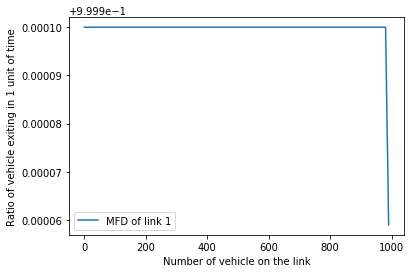

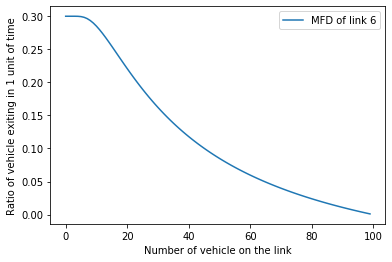

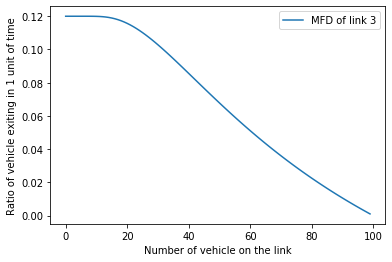

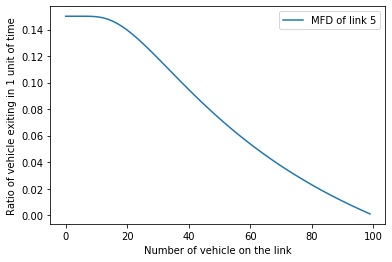

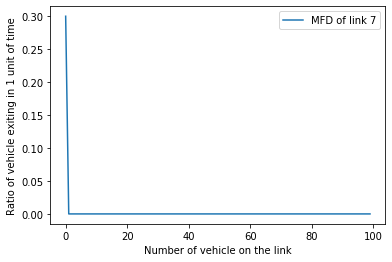

In [12]:
fonts = 10
g.plot_mfd(origin, fs = fonts)
g.plot_mfd(5, fs = fonts)
g.plot_mfd(2, fs = fonts)
g.plot_mfd(4, fs = fonts)
g.plot_mfd(dest, fs = fonts)

### C. Implementation of the controllers

#### Setting the parameters

In [13]:
# Brute force --> set the number of mesh points
nb_points_mesh = 50

# Greedy has no parameters

# Monte Carlo constant: set the number of trial
nb_trial_mc_constant = 50

# MPC Monte Carlo: set the number of trial and the frequency of trial
save_results_mpc = True
nb_trial_mc_mpc = 20
freq_redo_mc_mpc = 5

#### Brute force

In [14]:
# x0, nb_iteration, time_step and dest should be defined
# functions get_cost and matrix_from_u1_u2 should have been defined
u_brute_force, f_brute_force, score_brute_force, scores_brute_force_list = get_brute_force_results(x0, nb_iteration, time_step, get_cost, matrix_from_u1_u2, nb_points_mesh)


#### Greedy 1

In [15]:

# f_greedy_1, score_greedy_1 and u_greedy_list are global variable
greedy_controller_1 = lambda gvar, xvar, tvar: greedy_controller_1_aux(gvar, xvar, origin, dest)

f_greedy_1 = g.simulation_one_player(x0, nb_iteration, time_step, greedy_controller_1, [dest])
score_greedy_1 = get_cost(f_greedy_1)

u_greedy_list = np.zeros((nb_iteration,2))
for i in range(nb_iteration):
    matrix = greedy_controller_1_aux(g, f_greedy_1[i, :], origin, dest)
    u_greedy_list[i] = [matrix[0][2], matrix[1][4]]


#### Greedy controller 2

Greedy controller 2 put everyone one path that minimizes the instantenous travel time + marginal cost at every time step

In [16]:
## TO DO

#### Monte Carlo constant controller
Monte Carlo constant controller tries randomly some control and see which one works the best.

In [17]:
# Monte Carlo with constant controller

# x0, nb_iteration, time_step, origin and dest should be defined
# functions get_cost and matrix_from_u1_u2 should have been defined

# Monte Carlo controller should be changed if there is a final cost

# u_monte_carlo_constant are global variables corresponding to constant optimal control found with monte carlo
u_tested, u_monte_carlo_constant = monte_carlo_controller_aux(g, x0, nb_iteration, time_step, dest, get_cost, nb_trial_mc_constant, save_test=True)

monte_carlo_constant_controller = lambda gvar, xvar, tvar: matrix_from_u1_u2(gvar, u_monte_carlo_constant[0], u_monte_carlo_constant[1])

# f_brute_force and score_brute_force are global variables associated to optimal control found with brute force
f_monte_carlo_constant = g.simulation_one_player(x0, nb_iteration, time_step, monte_carlo_constant_controller, [dest])
score_monte_carlo_constant = get_cost(f_monte_carlo_constant)


#### Monte Carlo MPC controller

Monte Carlo MPC controller tries different inputs at every time step.
Instead of doing nb_iter iterations, the new code does: $$nb\_iter + nb\_trial\_per\_iteration*(\sum_{i=0}^{nb\_iter} i) = nb\_iter \Big(1 + \frac{1}{2} (nb\_iter + 1) * nb\_trial\_per\_iteration\Big)$$

This is computationally expensive. To reduce the amount of work to do, one can:
- not do the entire simulation during the MPC
- reduce the nb_trial_per_iteration by testing less controls
- reduce the nb_trial_per_iteration by doing MPC only 5 iterations
- reduce the nb_trial_per_iteration by memoizing good controller, and ony testing the good controllers randomly



In [18]:
# MPC

# Here at least u1_previous, u2_previous are global
# If results are saved save_results should also be global


def mpc_monte_carlo_controller(gv, x, t, nb_iter, tstep, des, cost_function, nb_trial, freq_redo, save_results=False):
    # previous controller are global variable
    global u1_previous, u2_previous
    
    if t == 0:
        # if t == 0 there is no previous controller
        min_cost_previous = np.inf
    else:
        # if this is not the time to re-do the MPC, return previous control
        if t % freq_redo != 0:
            if save_results:
                u_monte_carlo_mpc_list[t] = [u1_previous, u2_previous]
            return matrix_from_u1_u2(gv, u1_previous, u2_previous)
        # else find cost due to previous control
        u_monte_carlo_previous = [u1_previous, u2_previous]
        f = g.simulation_one_player(x, nb_iter-t, tstep, lambda gvar, xvar, tvar: matrix_from_u1_u2(gvar, u_monte_carlo_previous[0], u_monte_carlo_previous[1]), [des])
        min_cost_previous = get_cost(f)
    
    # try random control
    u_monte_carlo_tmp, min_cost_random =  monte_carlo_controller_aux(gv, x, nb_iter-t, tstep, des, cost_function, nb_trial, return_score=True)
    
    # if the new cost is better, than use the new control found randomly and update previous control
    if min_cost_random < min_cost_previous:
        u_tmp = u_monte_carlo_tmp
        [u1_previous, u2_previous] = u_tmp
    # otherwise return the previous control
    else:
        u_tmp = u_monte_carlo_previous
        
    if save_results:
        u_monte_carlo_mpc_list[t] = u_tmp
    return matrix_from_u1_u2(gv, u_tmp[0], u_tmp[1])


if save_results_mpc:
    u_monte_carlo_mpc_list = np.zeros((nb_iteration, 2))
    
controller_mpc = lambda gvar, xvar, tvar: mpc_monte_carlo_controller(gvar, xvar, tvar, nb_iteration, time_step, dest, get_cost, nb_trial_mc_mpc, freq_redo_mc_mpc, save_results=save_results_mpc)

f_monte_carlo_mpc = g.simulation_one_player(x0, nb_iteration, time_step, controller_mpc, [dest])
score_monte_carlo_mpc = get_cost(f_monte_carlo_mpc)


## Showing results

### 1. Brut force and Monte Carlo constant

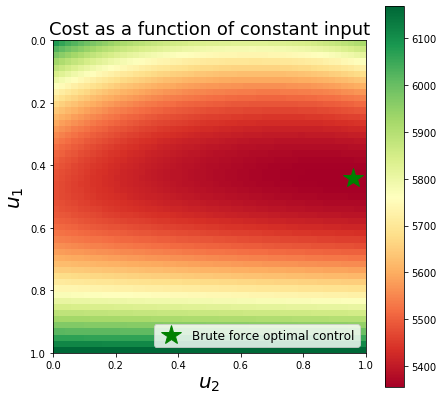

In [19]:
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["legend.loc"] = 'lower right'

plt.plot(u_brute_force[1], u_brute_force[0], "g*",  markersize=20, label="Brute force optimal control")
plt.imshow(scores_brute_force_list, cmap='RdYlGn', interpolation='none', extent=[0,1,1,0])
plt.ylabel("$u_1$", fontsize=20)
plt.xlabel("$u_2$", fontsize=20)
plt.title("Cost as a function of constant input", fontsize=18)
plt.legend(fontsize=12)
plt.colorbar()
plt.show()

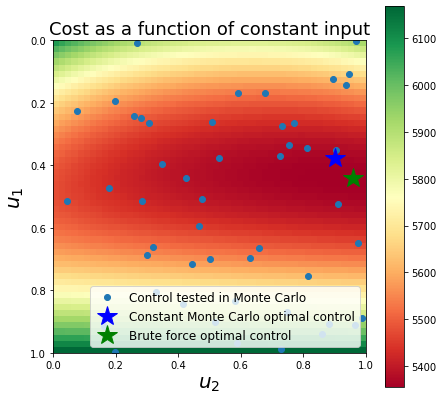

In [20]:
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["legend.loc"] = 'lower right'

plt.plot(u_tested[:,1], u_tested[:,0], 'o', label = "Control tested in Monte Carlo")
plt.plot(u_monte_carlo_constant[1], u_monte_carlo_constant[0], 'b*',  markersize=20, label="Constant Monte Carlo optimal control")
plt.plot(u_brute_force[1], u_brute_force[0], "g*",  markersize=20, label="Brute force optimal control")
plt.imshow(scores_brute_force_list, cmap='RdYlGn', interpolation='none', extent=[0,1,1,0])
plt.ylabel("$u_1$", fontsize=20)
plt.xlabel("$u_2$", fontsize=20)
plt.title("Cost as a function of constant input", fontsize=18)
plt.legend(fontsize=12)
plt.colorbar()
plt.show()

In [21]:
# setting plt paramaters
plt.rcParams["figure.figsize"] = (5,5)
plt.rcParams["legend.loc"] = 'best'

### 2. Controllers

----- Brute force constant -----
Cost: 5355.281157531924


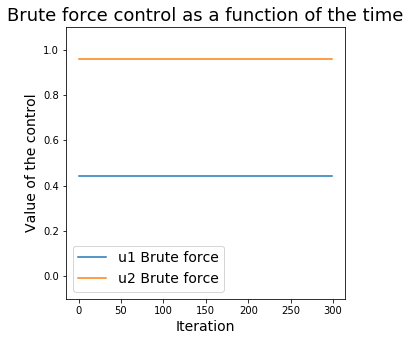

----- Greedy 1 -----
Cost: 5429.879861444365


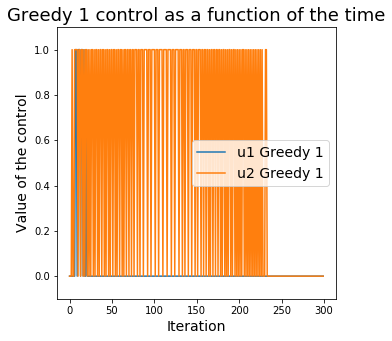

----- Monte Carlo constant -----
Cost: 5364.877738757808
Nb trial: 50


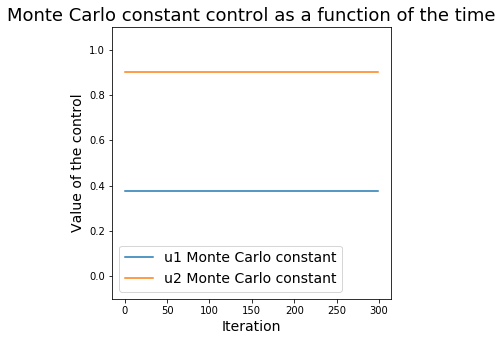

----- Monte Carlo MPC -----
Cost: 5351.707387549778
Nb trial: 20
MPC every 5 time step


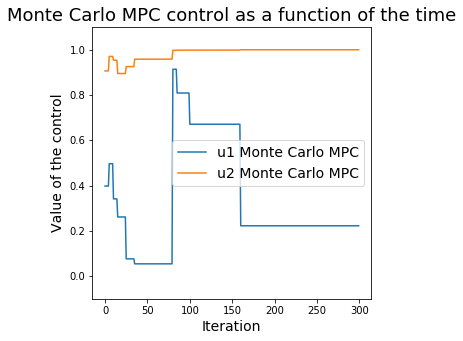

In [22]:
# nb_iteration should be defined
nb_controls = 2


def plot_control(u_list, control_name, nb_c):
    for i in range(nb_c):
        plt.plot(u_list[:,i], label="u" + str(i+1) + " " + control_name)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Value of the control", fontsize=14)
    plt.ylim([-0.1,1.1])
    plt.title(control_name + " control as a function of the time", fontsize=18)
    plt.legend(fontsize=14)
    plt.show()

print("----- Brute force constant -----")
print("Cost: " + str(score_brute_force))
u_brute_force_list = np.ones((nb_iteration, nb_controls))
for i in range(nb_controls):
    u_brute_force_list[:,i] = u_brute_force_list[:,i]*u_brute_force[i]
plot_control(u_brute_force_list, "Brute force", nb_controls)


print("----- Greedy 1 -----")
print("Cost: " + str(score_greedy_1))
plot_control(u_greedy_list, "Greedy 1", nb_controls)


# print("----- Greedy 2 -----")

print("----- Monte Carlo constant -----")
print("Cost: " + str(score_monte_carlo_constant))
print("Nb trial: " + str(nb_trial_mc_constant))
u_monte_carlo_constant_list = np.ones((nb_iteration, nb_controls))
for i in range(nb_controls):
    u_monte_carlo_constant_list[:,i] = u_monte_carlo_constant_list[:,i]*u_monte_carlo_constant[i]
plot_control(u_monte_carlo_constant_list, "Monte Carlo constant", nb_controls)

print("----- Monte Carlo MPC -----")
print("Cost: " + str(score_monte_carlo_mpc))
print("Nb trial: " + str(nb_trial_mc_mpc))
print("MPC every " + str(freq_redo_mc_mpc) + " time step")
plot_control(u_monte_carlo_mpc_list, "Monte Carlo MPC", nb_controls)

### 3. Flows

----- Brute force constant -----
Cost: 5355.281157531924


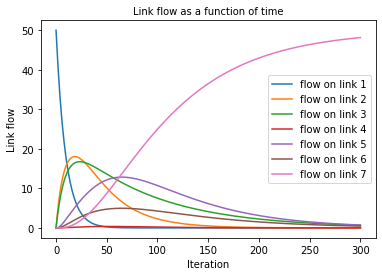

----- Greedy 1 -----
Cost: 5429.879861444365


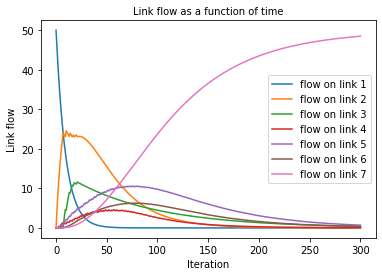

----- Monte Carlo constant -----
Cost: 5364.877738757808
Nb trial: 50


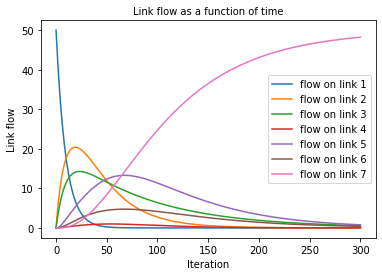

----- Monte Carlo MPC -----
Cost: 5351.707387549778
Nb trial: 20
MPC every 5 time step


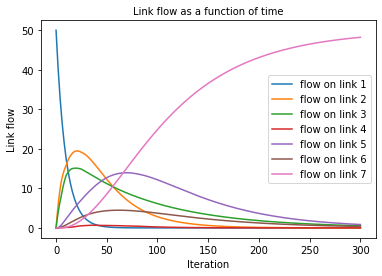

In [23]:
print("----- Brute force constant -----")
print("Cost: " + str(score_brute_force))
g.plot_flow(f_brute_force)


print("----- Greedy 1 -----")
print("Cost: " + str(score_greedy_1))
g.plot_flow(f_greedy_1)


# print("----- Greedy 2 -----")

print("----- Monte Carlo constant -----")
print("Cost: " + str(score_monte_carlo_constant))
print("Nb trial: " + str(nb_trial_mc_constant))
g.plot_flow(f_monte_carlo_constant)

print("----- Monte Carlo MPC -----")
print("Cost: " + str(score_monte_carlo_mpc))
print("Nb trial: " + str(nb_trial_mc_mpc))
print("MPC every " + str(freq_redo_mc_mpc) + " time step")
g.plot_flow(f_monte_carlo_mpc)


### 4. Travel time

----- Brute force constant -----
Cost: 5355.281157531924


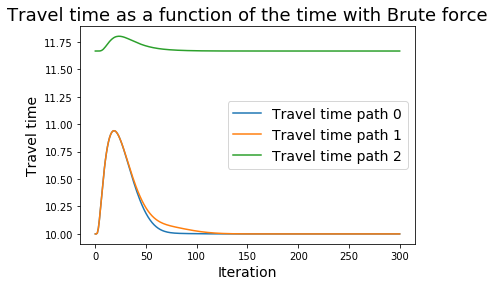

----- Greedy 1 -----
Cost: 5429.879861444365


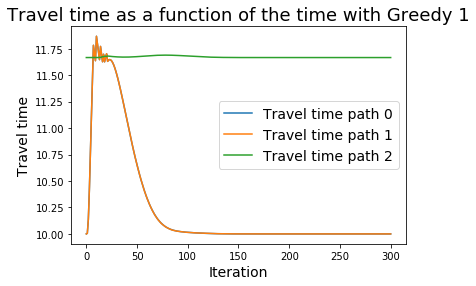

----- Monte Carlo constant -----
Cost: 5364.877738757808
Nb trial: 50


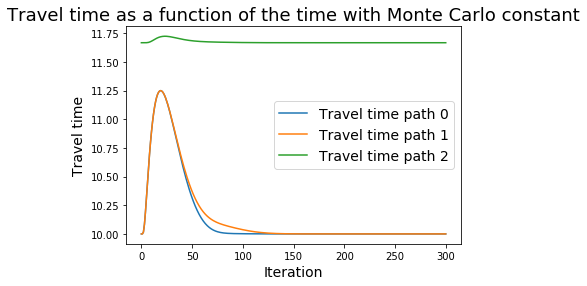

----- Monte Carlo MPC -----
Cost: 5351.707387549778
Nb trial: 20
MPC every 5 time step


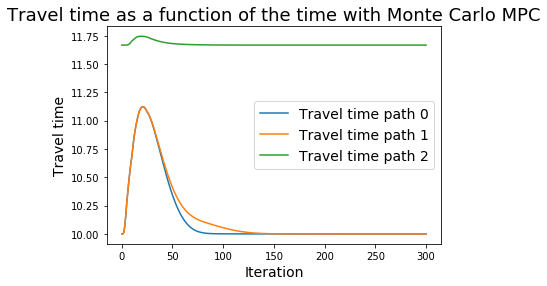

In [24]:
def get_travel_time(g, x):
    travel_time = np.zeros((x.shape[0], 3))
    for i in range(x.shape[0]):
        tt = g.get_mean_travel_time(x[i, :])
        travel_time[i] = [tt[1] + tt[3] + tt[5], tt[1] + tt[4], tt[2] + tt[5]]
    return travel_time

def plot_travel_time(g, f, control_name):
    travel_time = get_travel_time(g, f)
    for i in range(travel_time.shape[1]):
        plt.plot(travel_time[:,i], label="Travel time path " + str(i))
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Travel time", fontsize=14)
    plt.title("Travel time as a function of the time with " + control_name, fontsize=18)
    plt.legend(fontsize=14)
    plt.show()
    
print("----- Brute force constant -----")
print("Cost: " + str(score_brute_force))
plot_travel_time(g, f_brute_force, "Brute force")


print("----- Greedy 1 -----")
print("Cost: " + str(score_greedy_1))
plot_travel_time(g, f_greedy_1, "Greedy 1")

# print("----- Greedy 2 -----")

print("----- Monte Carlo constant -----")
print("Cost: " + str(score_monte_carlo_constant))
print("Nb trial: " + str(nb_trial_mc_constant))
plot_travel_time(g, f_monte_carlo_constant, "Monte Carlo constant")


print("----- Monte Carlo MPC -----")
print("Cost: " + str(score_monte_carlo_mpc))
print("Nb trial: " + str(nb_trial_mc_mpc))
print("MPC every " + str(freq_redo_mc_mpc) + " time step")
plot_travel_time(g, f_monte_carlo_mpc, "Monte Carlo MPC")


### 5. Comparison

In [25]:
break

SyntaxError: 'break' outside loop (<ipython-input-25-6aaf1f276005>, line 4)

In [ ]:
# showing the simulation
%matplotlib notebook
# %matplotlib inline
import matplotlib.animation as animation

f = f_greedy

links = np.zeros((g.nb_links, 4))
for i in range(g.nb_links):
    links[i,:2] = g.graph[g.connections[i,0]]["location"]
    links[i,2:] = g.graph[g.connections[i,1]]["location"]

cdict = {'red': (1.0, 0.0, 0.0), 'green': (0.0, 1.0, 0.0)}

fig, ax = plt.subplots()
ln = []
for i in range(g.nb_links):
#     print(i)
    ln.append(plt.quiver(links[i, 0], links[i, 1], links[i, 2]-links[i, 0], links[i, 3]-links[i, 1], color="b", angles='xy', scale_units='xy', scale=1))
#     plt.quiver(links[i, 0], links[i, 1], links[i, 2]-links[i, 0], links[i, 3]-links[i, 1], color="b", angles='xy', scale_units='xy', scale=1)
plt.xlim([-0.5, 4.5])
plt.ylim([-1.5, 1.5])

def init():
    return ln,

def update(frame):
    c = np.array([(1-f[frame]/50)**2 * cdict["green"][i] + (f[frame]/50) * cdict["red"][i] for i in range(3)]).T
    for i in range(7):
        ln[i].set_color(c[i])
    return ln,

ani = animation.FuncAnimation(fig, update, frames = 200,
                    init_func=init, blit=True)
plt.show()

# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=600)

# ani.save('test_simulation_2.mp4', writer=writer)
